In [113]:
# !pip install scikit-optimize
# from google.colab import drive
# drive.mount('/content/drive')

# Imports

In [272]:
import time
import timeit
import math

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from IPython.display import display

from functools import reduce
from operator import mul

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn import preprocessing

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import pearsonr, probplot, shapiro, kstest, norm, anderson, skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from scipy.stats import ttest_rel

# Data

## Importing and cleaning

In [115]:
# Note: Data are asking prices on Auto Trader; these are not necessarily the price they sell for

# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/car_data.csv')
data = pd.read_csv('data/car_data.csv')

In [116]:
display(data.head())
print()
display(data.describe(include='all'))
print()
print('Unique values')
display(data.nunique().sort_values())
print()
print('Null values')
display(data.isnull().sum().sort_values())

,Price,Year,Generation,Trim,Mileage,Distance,Seller
0,5995,2017,7,ST-3,102857,7,Private
1,11995,2017,7,ST-3,30100,21,Trade
2,14295,2019,8,ST-3,42150,26,Trade
3,10800,2017,7,ST-3,46000,29,Trade
4,21495,2022,8,ST-3,10000,29,Trade


,Price,Year,Generation,Trim,Mileage,Distance,Seller
count,635.000000,635.000000,635.000000,635,635.000000,635.000000,635
unique,NaN,NaN,NaN,2,NaN,NaN,2
top,NaN,NaN,NaN,ST-3,NaN,NaN,Trade
freq,NaN,NaN,NaN,364,NaN,NaN,497
mean,11913.724409,2016.223622,7.464567,NaN,47636.426772,175.433071,NaN
std,5391.029049,36.549181,0.499136,NaN,27875.479021,71.853842,NaN
min,3030.000000,1100.000000,7.000000,NaN,9.000000,7.000000,NaN
25%,7487.500000,2015.000000,7.000000,NaN,23339.000000,135.000000,NaN
50%,10000.000000,2017.000000,7.000000,NaN,47000.000000,174.000000,NaN
75%,15992.500000,2020.000000,8.000000,NaN,67664.000000,208.000000,NaN



Unique values


Generation      2
Trim            2
Seller          2
Year           14
Distance      222
Price         400
Mileage       507
dtype: int64


Null values


Price         0
Year          0
Generation    0
Trim          0
Mileage       0
Distance      0
Seller        0
dtype: int64

In [117]:
# Generation: 7 to 1, 8 to 0 (i.e. mine is 1)
# Trim: ST-3 to 1, ST-2 to 0 (i.e. mine is 1)
# Seller: Private to 1, trade to 0 (i.e. mine is 1)

data['Generation'] = data['Generation'].map({7:1, 8:0})
data['Trim'] = data['Trim'].map({'ST-3':1, 'ST-2':0})
data['Seller'] = data['Seller'].map({'Private':1, 'Trade':0})
# data.rename(columns={'Seller':'Seller'}, inplace=True)

display(data.describe(include='all'))

,Price,Year,Generation,Trim,Mileage,Distance,Seller
count,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000
mean,11913.724409,2016.223622,0.535433,0.573228,47636.426772,175.433071,0.217323
std,5391.029049,36.549181,0.499136,0.494998,27875.479021,71.853842,0.412749
min,3030.000000,1100.000000,0.000000,0.000000,9.000000,7.000000,0.000000
25%,7487.500000,2015.000000,0.000000,0.000000,23339.000000,135.000000,0.000000
50%,10000.000000,2017.000000,1.000000,1.000000,47000.000000,174.000000,0.000000
75%,15992.500000,2020.000000,1.000000,1.000000,67664.000000,208.000000,0.000000
max,26950.000000,2025.000000,1.000000,1.000000,164530.000000,462.000000,1.000000


In [118]:
def boxplot_all_columns(data, title):
    plt.figure(figsize=(14, 7))
    plt.suptitle(f'Boxplots for {title}', fontsize=16)
    numeric_columns = data.select_dtypes(include=['number']).columns
    for i, column in enumerate(numeric_columns):
        plt.subplot(2, 4, i + 1)
        data.boxplot(column=[column])
        plt.title(column)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

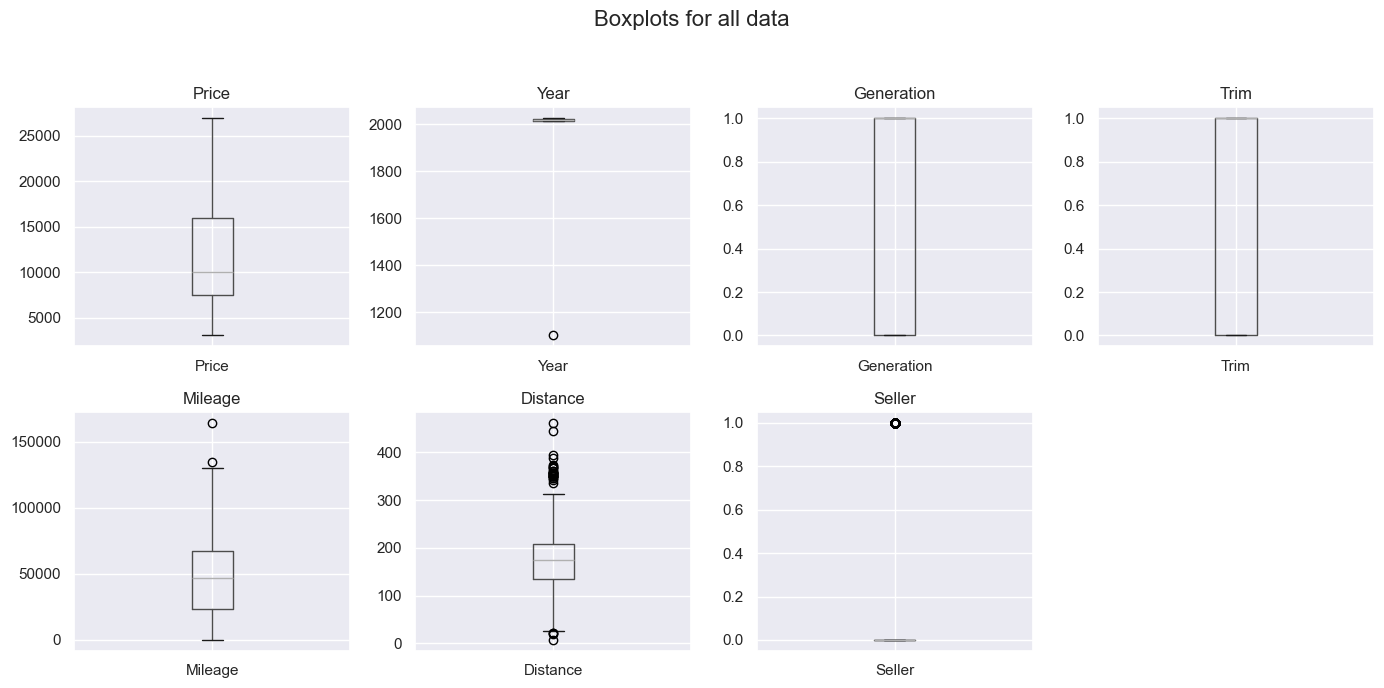

In [119]:
boxplot_all_columns(data, 'all data')

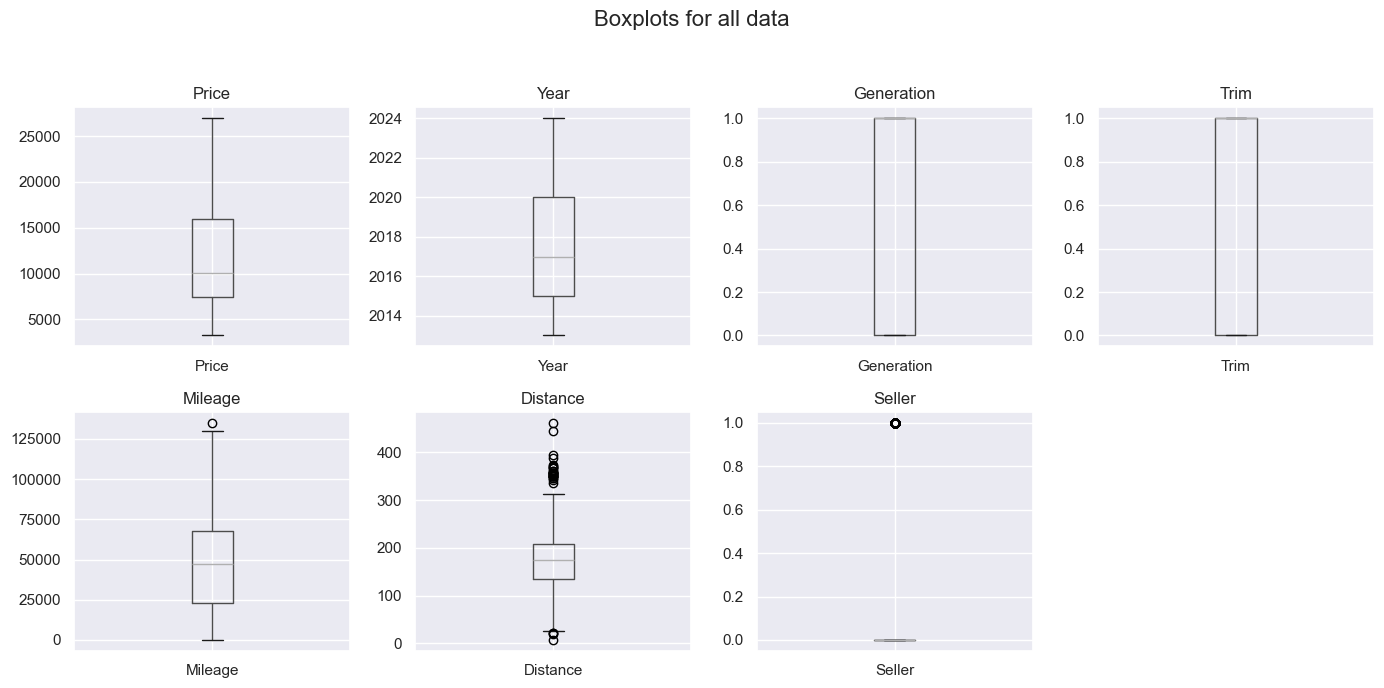

In [120]:
# Fixed outlier values come from manually checking raw data

data[data['Year']==1100]
data.loc[17, 'Year'] = 2020

data[data['Year']==2025]
data.loc[80, 'Year'] = 2016
data.loc[110, 'Year'] = 2019

data['Mileage'].sort_values().tail()
data.drop(index=53, inplace=True)

boxplot_all_columns(data, 'all data')

## Data splitting

In [121]:
# Data split by categories (generation, trim, seller type)

gen7_data = data[data['Generation'] == 1]

gen7_st3_data = gen7_data[gen7_data['Trim'] == 1]
gen7_st2_data = gen7_data[gen7_data['Trim'] == 0]

gen7_private_data = gen7_data[gen7_data['Seller'] == 1]
gen7_trade_data = gen7_data[gen7_data['Seller'] == 0]

gen7_st3_private_data = gen7_st3_data[gen7_st3_data['Seller'] == 1]
gen7_st3_trade_data = gen7_st3_data[gen7_st3_data['Seller'] == 0]

gen7_st2_private_data = gen7_st2_data[gen7_st2_data['Seller'] == 1]
gen7_st2_trade_data = gen7_st2_data[gen7_st2_data['Seller'] == 0]

gen8_data = data[data['Generation'] == 0]

gen8_st3_data = gen8_data[gen8_data['Trim'] == 1]
gen8_st2_data = gen8_data[gen8_data['Trim'] == 0]

gen8_private_data = gen8_data[gen8_data['Seller'] == 1]
gen8_trade_data = gen8_data[gen8_data['Seller'] == 0]

gen8_st3_private_data = gen8_st3_data[gen8_st3_data['Seller'] == 1]
gen8_st3_trade_data = gen8_st3_data[gen8_st3_data['Seller'] == 0]

gen8_st2_private_data = gen8_st2_data[gen8_st2_data['Seller'] == 1]
gen8_st2_trade_data = gen8_st2_data[gen8_st2_data['Seller'] == 0]

# gen7_st3_private_data_dropped = gen7_st3_private_data.drop(['Generation', 'Trim', 'Seller'], axis=1) # these are effectively equivalent
gen7_st3_private_data_dropped = gen7_st3_private_data.loc[:, gen7_st3_private_data.nunique() != 1]

st3_data = data[data['Trim'] == 1]
st3_data_dropped = st3_data.loc[:, st3_data.nunique() != 1]


In [122]:
mine_all = pd.DataFrame({
    'Year': [2017],
    'Generation': [1],
    'Trim': [1],
    'Mileage': [38000],
    'Distance': [1],
    'Seller': [1]
})

mine_simple = pd.DataFrame({
    'Year': [2017],
    'Mileage': [38000],
    'Distance': [1]
})

# Exploratory data analysis

## Price graphs

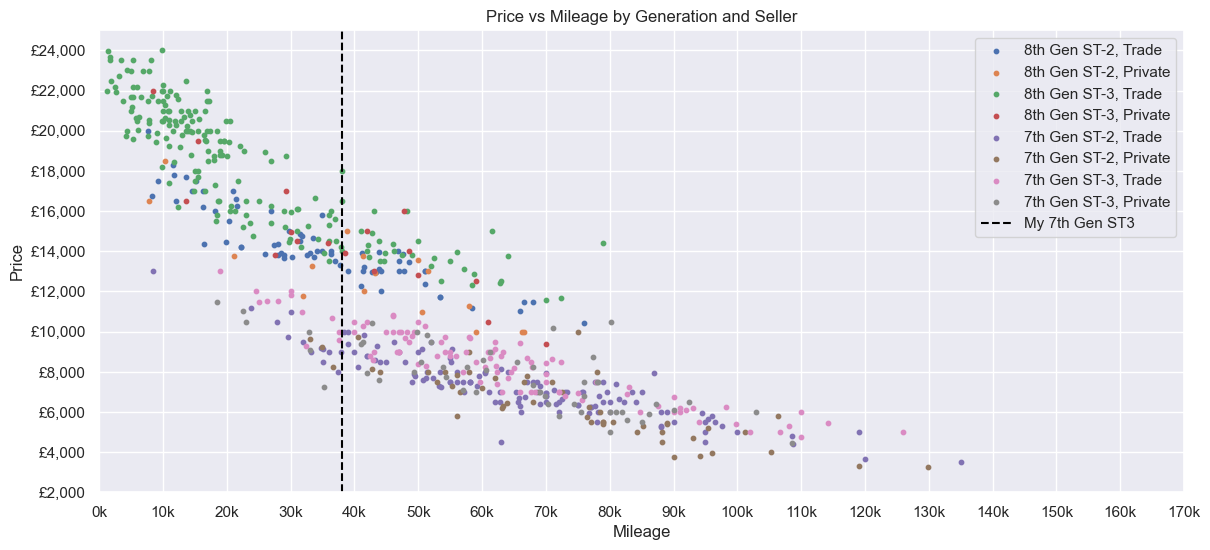

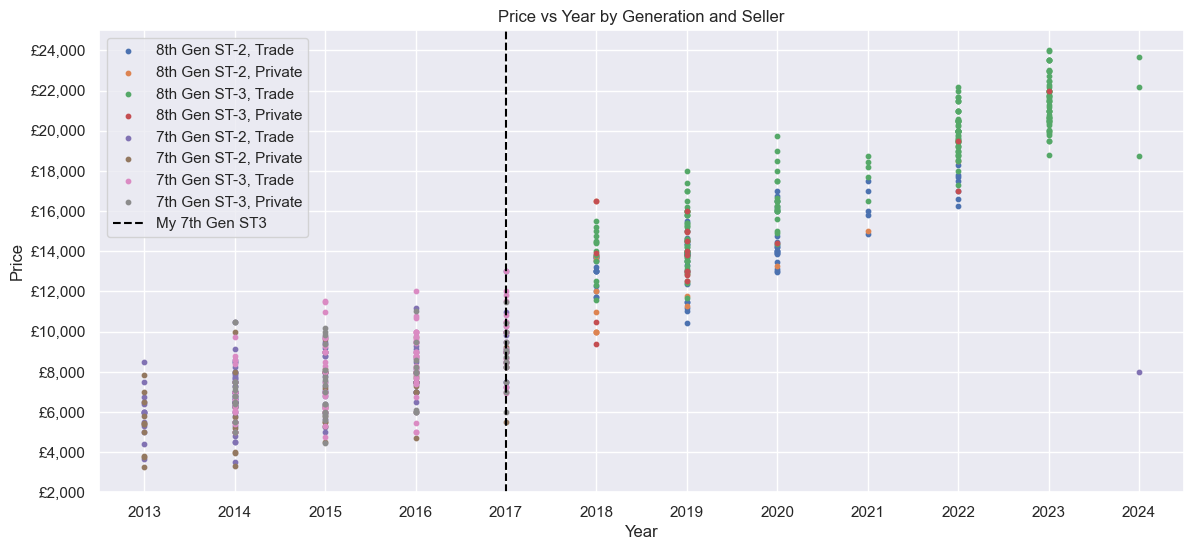

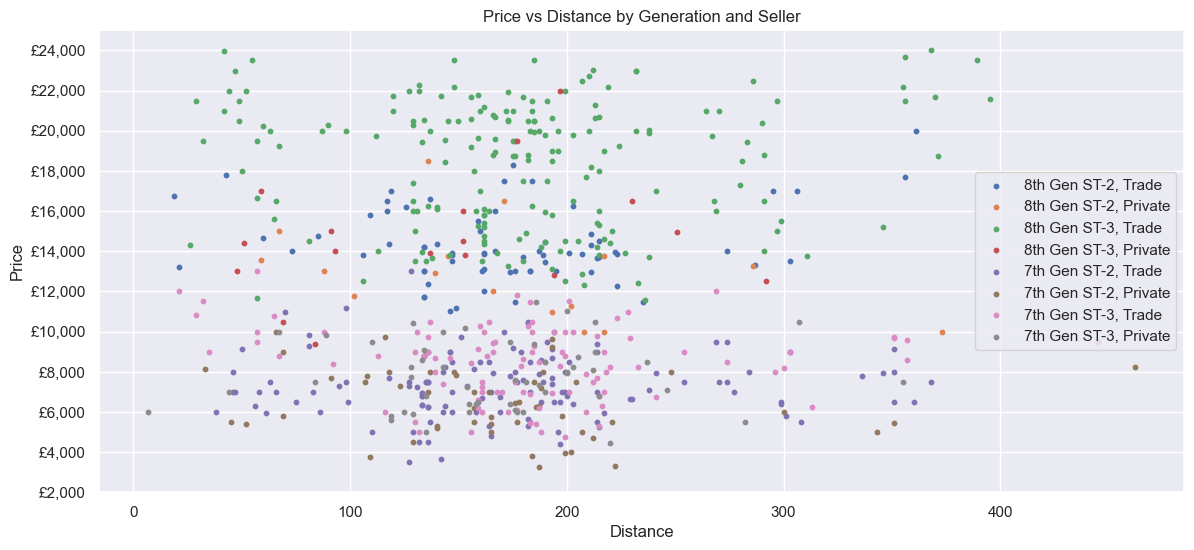

In [123]:
def plot_price_vs(x_col):
    plt.figure(figsize=(14, 6))
    plt.title(f'Price vs {x_col} by Generation and Seller')

    y_gen7_st2_private = gen7_st2_private_data['Price']
    y_gen7_st2_trade = gen7_st2_trade_data['Price']
    x_gen7_st2_private = gen7_st2_private_data[x_col]
    x_gen7_st2_trade = gen7_st2_trade_data[x_col]

    y_gen7_st3_private = gen7_st3_private_data['Price']
    y_gen7_st3_trade = gen7_st3_trade_data['Price']
    x_gen7_st3_private = gen7_st3_private_data[x_col]
    x_gen7_st3_trade = gen7_st3_trade_data[x_col]

    y_gen8_st2_private = gen8_st2_private_data['Price']
    y_gen8_st2_trade = gen8_st2_trade_data['Price']
    x_gen8_st2_private = gen8_st2_private_data[x_col]
    x_gen8_st2_trade = gen8_st2_trade_data[x_col]

    y_gen8_st3_private = gen8_st3_private_data['Price']
    y_gen8_st3_trade = gen8_st3_trade_data['Price']
    x_gen8_st3_private = gen8_st3_private_data[x_col]
    x_gen8_st3_trade = gen8_st3_trade_data[x_col]

    plt.scatter(x_gen8_st2_trade, y_gen8_st2_trade, s=10, label='8th Gen ST-2, Trade')
    plt.scatter(x_gen8_st2_private, y_gen8_st2_private, s=10, label='8th Gen ST-2, Private')

    plt.scatter(x_gen8_st3_trade, y_gen8_st3_trade, s=10, label='8th Gen ST-3, Trade')
    plt.scatter(x_gen8_st3_private, y_gen8_st3_private, s=10, label='8th Gen ST-3, Private')

    plt.scatter(x_gen7_st2_trade, y_gen7_st2_trade, s=10, label='7th Gen ST-2, Trade')
    plt.scatter(x_gen7_st2_private, y_gen7_st2_private, s=10, label='7th Gen ST-2, Private')

    plt.scatter(x_gen7_st3_trade, y_gen7_st3_trade, s=10, label='7th Gen ST-3, Trade')
    plt.scatter(x_gen7_st3_private, y_gen7_st3_private, s=10, label='7th Gen ST-3, Private')

    if x_col == 'Mileage':
        plt.axvline(38000, color='black', linestyle='--', label='My 7th Gen ST3')
    elif x_col == 'Year':
        plt.axvline(2017, color='black', linestyle='--', label='My 7th Gen ST3')

    ax = plt.gca()

    plt.ylabel('Price')
    plt.ylim(2000,25000)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2000))
    def currency_formatter(y, pos):
        return '£{:,.0f}'.format(y)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))

    plt.xlabel(f'{x_col}')
    if x_col == 'Mileage':
      plt.xlim(0,170000)
      ax.xaxis.set_major_locator(ticker.MultipleLocator(10000))
      def thousands_formatter(x, pos):
          return '{:.0f}k'.format(x / 1000)
      ax.xaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
    elif x_col == 'Year':
      plt.xlim(2012.5, 2024.5)
      ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.grid(True)
    plt.legend()
    plt.show()

plot_price_vs('Mileage')
plot_price_vs('Year')
plot_price_vs('Distance')

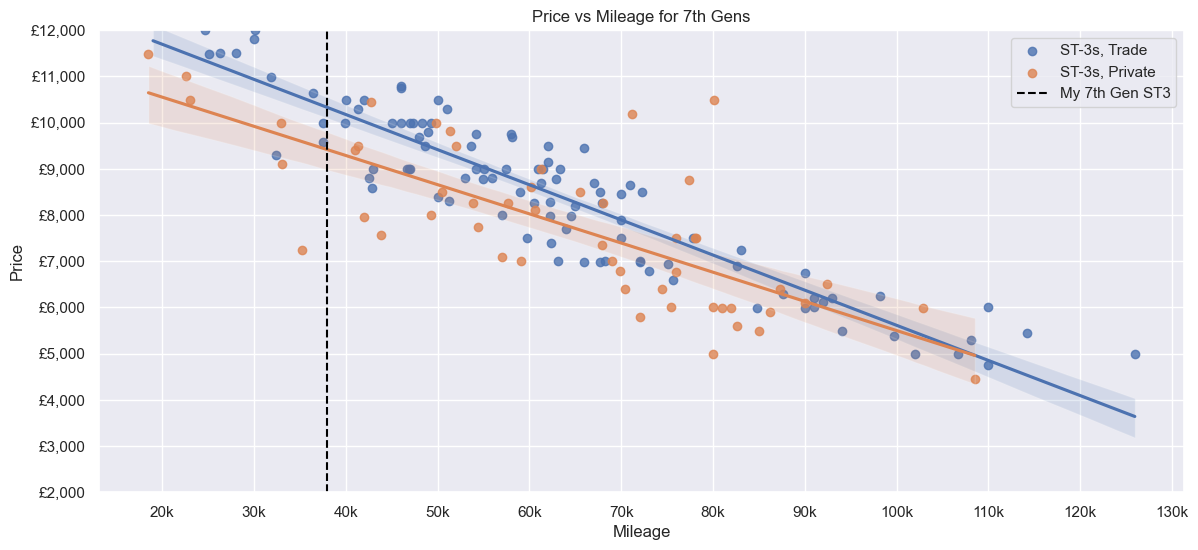

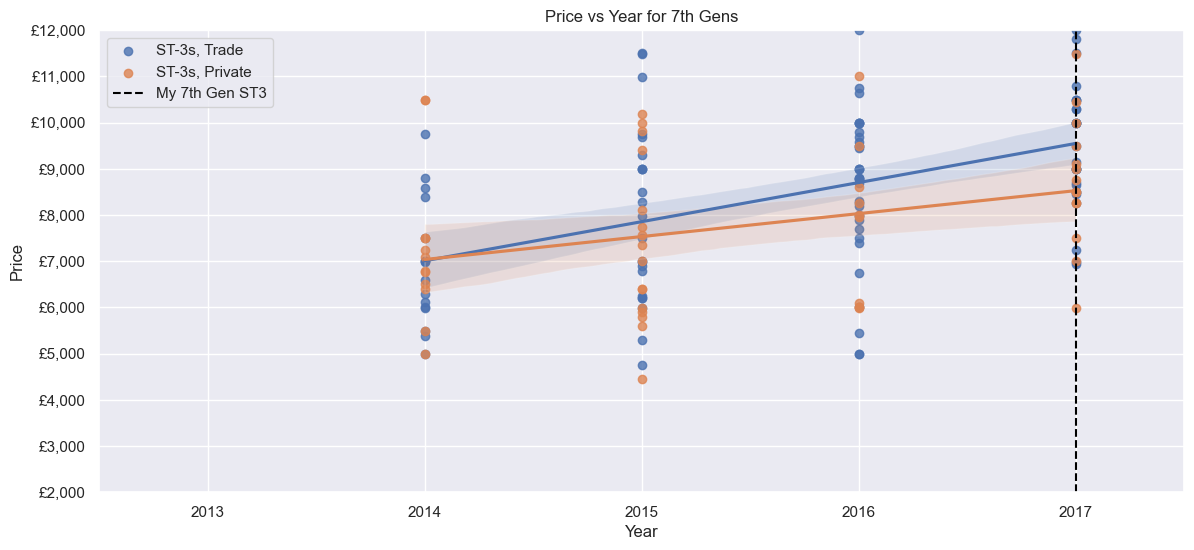

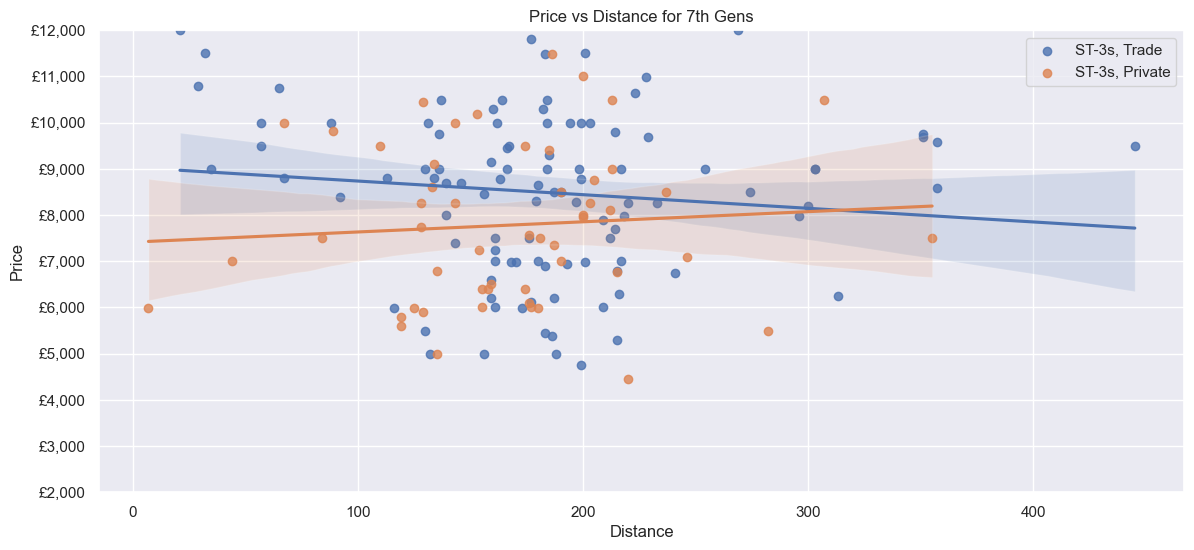

In [124]:
def plot_price_vs_gen7(x_col):
  plt.figure(figsize=(14, 6))
  plt.title(f'Price vs {x_col} for 7th Gens')

  # ax = sns.regplot(data=gen7_st2_trade_data, x=x_col, y='Price', label='ST-2s, Trade')
  # ax = sns.regplot(data=gen7_private_data, x=x_col, y='Price', label='Privates', scatter_kws={'s': 1})
  # ax = sns.regplot(data=gen7_st2_private_data, x=x_col, y='Price', label='ST-2s, Private')
  ax = sns.regplot(data=gen7_st3_trade_data, x=x_col, y='Price', label='ST-3s, Trade')
  ax = sns.regplot(data=gen7_st3_private_data, x=x_col, y='Price', label='ST-3s, Private')

  if x_col == 'Mileage':
      plt.axvline(38000, color='black', linestyle='--', label='My 7th Gen ST3')
  elif x_col == 'Year':
      plt.axvline(2017, color='black', linestyle='--', label='My 7th Gen ST3')

  plt.ylabel('Price')
  plt.ylim(2000, 12000)
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))
  def currency_formatter(y, pos):
      return '£{:,.0f}'.format(y)
  ax.yaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))

  plt.xlabel(f'{x_col}')
  if x_col == 'Mileage':
    # plt.xlim(10000, 170000)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10000))
    def thousands_formatter(x, pos):
        return '{:.0f}k'.format(x / 1000)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
  elif x_col == 'Year':
    plt.xlim(2012.5, 2017.5)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.grid(True)
  plt.legend()
  plt.show()

plot_price_vs_gen7('Mileage')
plot_price_vs_gen7('Year')
plot_price_vs_gen7('Distance')

## Histograms

In [125]:
def histogram_all_columns(data, title):
    plt.figure(figsize=(14, 7))
    plt.suptitle(f'Histograms for {title}', fontsize=16)
    for i, column in enumerate(data.columns):
      plt.subplot(2,4,i+1)
      # plt.subplots_adjust(hspace=0.5, wspace=0.5)
      sns.histplot(data[column], kde=True)
      plt.title(column)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

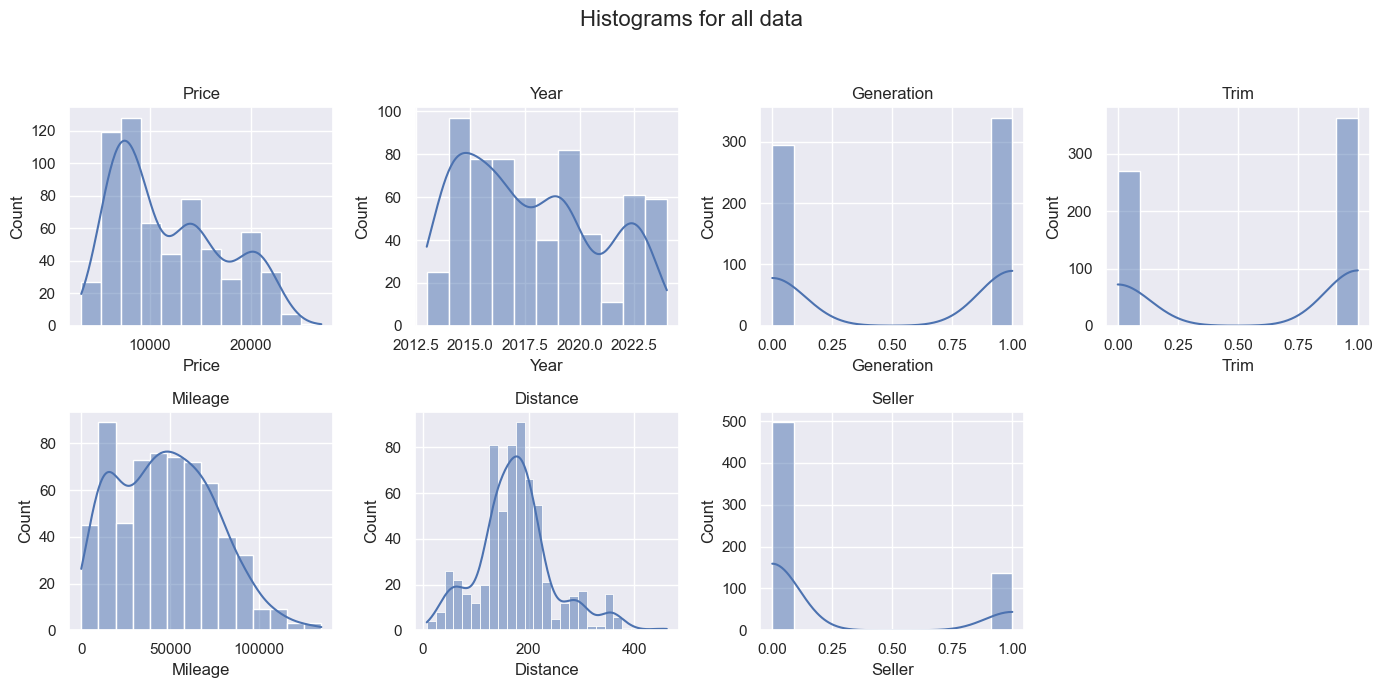

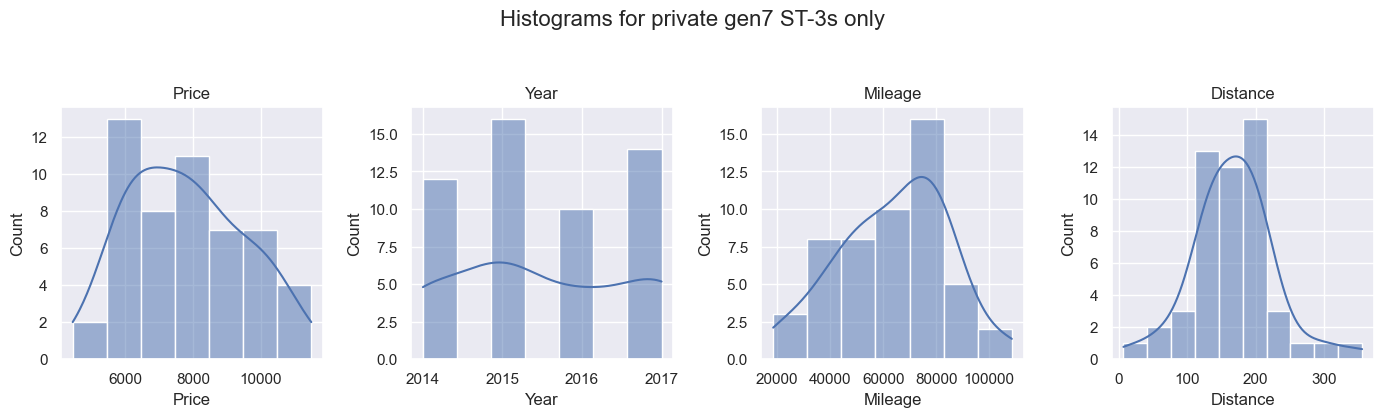

In [126]:
histogram_all_columns(data, 'all data')
# histogram_all_columns(gen7_data, 'gen7 only')
histogram_all_columns(gen7_st3_private_data_dropped, 'private gen7 ST-3s only')

## Q-Q plots

In [127]:
def qq_all_columns(data, title):
    plt.figure(figsize=(14, 7))
    plt.suptitle(f'Q-Q plots for {title}', fontsize=16)
    for i, column in enumerate(data.columns):
      plt.subplot(2,4,i+1)
      probplot(data[column], dist="norm", plot=plt)
      plt.title(column)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

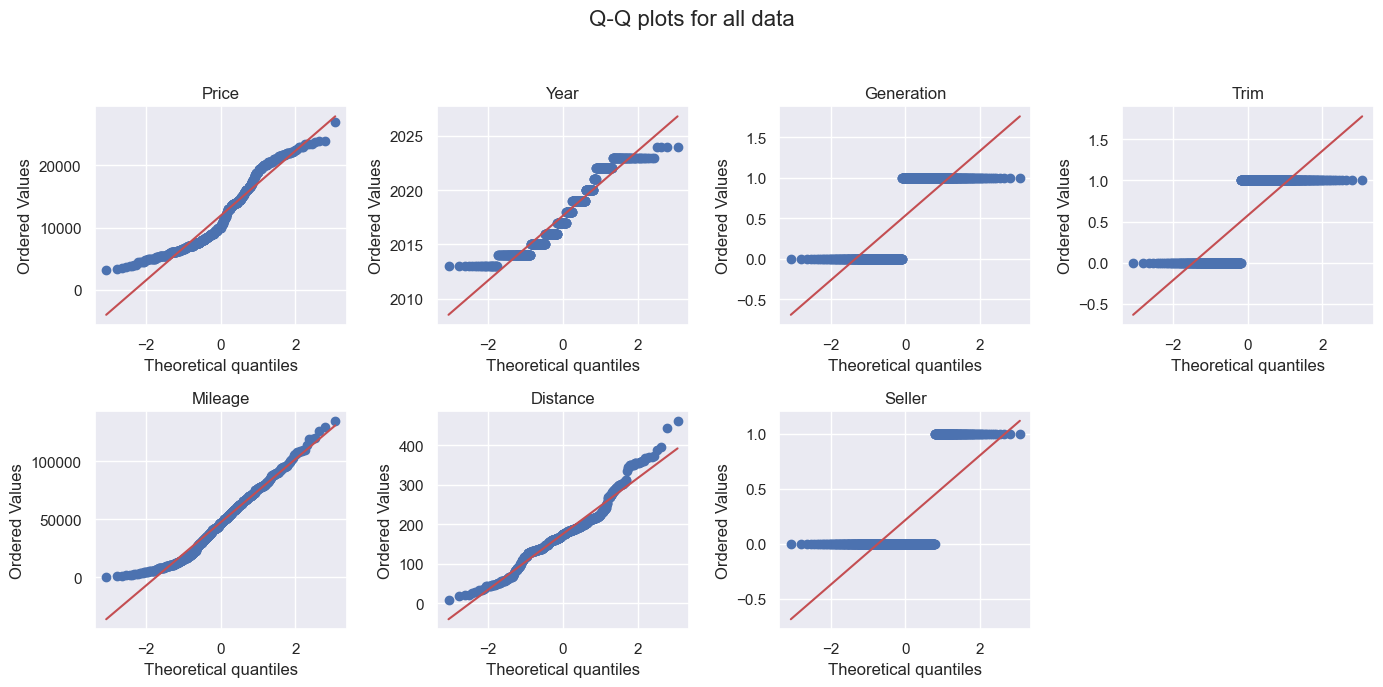

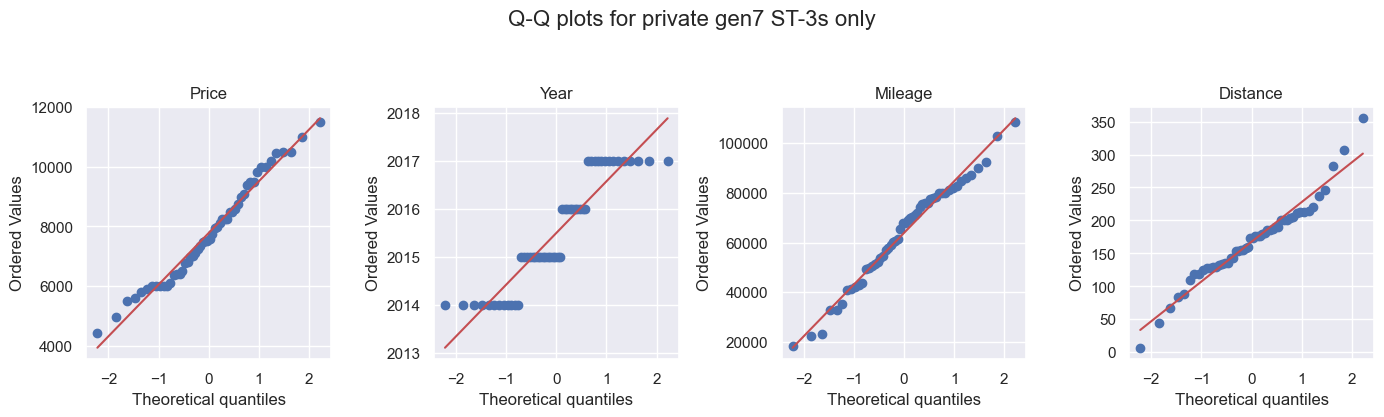

In [128]:
qq_all_columns(data, 'all data')
# qq_all_columns(gen7_data, 'gen7s only')
qq_all_columns(gen7_st3_private_data_dropped, 'private gen7 ST-3s only')

## Normality statistics

In [129]:
def normality_all_columns(data):
    results = []
    for column in data.columns:
      stat_s, p_s = shapiro(data[column])
      stat_ks, p_ks = kstest(data[column], 'norm', args=(data[column].mean(), data[column].std()))
      skewness = skew(data[column])
      kurt = kurtosis(data[column])
      results.append({'Feature': column,
                      'Shapiro statistic': round(stat_s,3), 'Shapiro p-value': round(p_s,3),
                      'KS statistic': round(stat_ks,3), 'KS p-value': round(p_ks,3),
                      'Skew': round(skewness,3), 'Kurtosis': round(kurt,3)})
    results_df = pd.DataFrame(results)
    return results_df

In [130]:
display(normality_all_columns(data))
# display(normality_all_columns(gen7_data))
display(normality_all_columns(gen7_st3_private_data_dropped))

,Feature,Shapiro statistic,Shapiro p-value,KS statistic,KS p-value,Skew,Kurtosis
0,Price,0.929,0.0,0.140,0.000,0.532,-0.904
1,Year,0.926,0.0,0.143,0.000,0.351,-1.085
2,Generation,0.635,0.0,0.359,0.000,-0.139,-1.981
3,Trim,0.629,0.0,0.379,0.000,-0.293,-1.914
4,Mileage,0.975,0.0,0.064,0.011,0.320,-0.516
5,Distance,0.961,0.0,0.104,0.000,0.575,1.074
6,Seller,0.507,0.0,0.484,0.000,1.380,-0.097


,Feature,Shapiro statistic,Shapiro p-value,KS statistic,KS p-value,Skew,Kurtosis
0,Price,0.973,0.283,0.082,0.845,0.265,-0.804
1,Year,0.851,0.000,0.210,0.018,0.083,-1.360
2,Mileage,0.980,0.538,0.098,0.669,-0.255,-0.429
3,Distance,0.964,0.117,0.101,0.632,0.298,1.562


## Correlations

In [282]:
def correlate(data, type):
    corr = data.corr(method=type)
    display(corr)
    plot_corr(corr)

def plot_corr(corr):
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.color_palette("Spectral", as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True)
    plt.show()

,Price,Year,Generation,Trim,Mileage,Distance,Seller
Price,1.000000,0.941650,-0.859152,0.420945,-0.886435,0.028505,-0.312114
Year,0.941650,1.000000,-0.861673,0.390371,-0.793773,0.016833,-0.273131
Generation,-0.859152,-0.861673,1.000000,-0.249905,0.693170,-0.009449,0.236227
Trim,0.420945,0.390371,-0.249905,1.000000,-0.304463,0.040346,-0.073129
Mileage,-0.886435,-0.793773,0.693170,-0.304463,1.000000,-0.013497,0.269382
Distance,0.028505,0.016833,-0.009449,0.040346,-0.013497,1.000000,-0.070556
Seller,-0.312114,-0.273131,0.236227,-0.073129,0.269382,-0.070556,1.000000


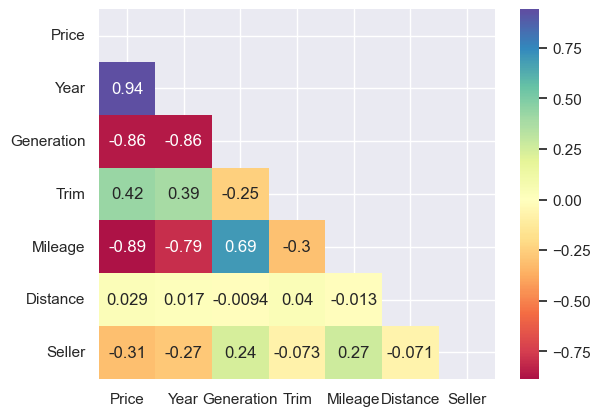

In [284]:
correlate(data, 'pearson')

,Price,Year,Generation,Trim,Mileage,Distance,Seller
Price,1.000000,0.783938,-0.702404,0.339671,-0.761685,0.017687,-0.254650
Year,0.783938,1.000000,-0.741930,0.337995,-0.634260,0.012161,-0.227199
Generation,-0.702404,-0.741930,1.000000,-0.249905,0.581224,-0.018271,0.236227
Trim,0.339671,0.337995,-0.249905,1.000000,-0.254256,0.054567,-0.073129
Mileage,-0.761685,-0.634260,0.581224,-0.254256,1.000000,-0.006343,0.228150
Distance,0.017687,0.012161,-0.018271,0.054567,-0.006343,1.000000,-0.060868
Seller,-0.254650,-0.227199,0.236227,-0.073129,0.228150,-0.060868,1.000000


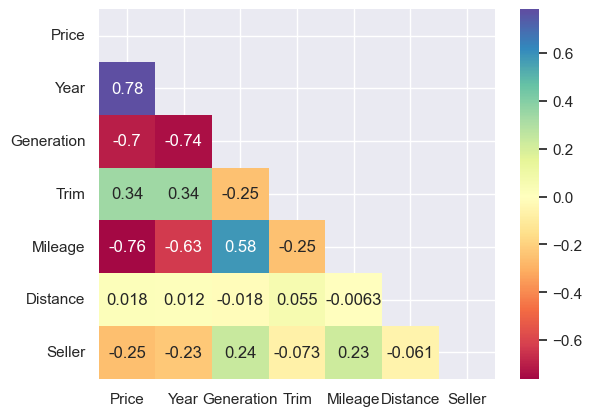

In [285]:
correlate(data, 'kendall')

,Price,Year,Generation,Trim,Mileage,Distance,Seller
Price,1.000000,0.915724,-0.858432,0.415123,-0.919756,0.025860,-0.311216
Year,0.915724,1.000000,-0.864281,0.393734,-0.800138,0.016743,-0.264667
Generation,-0.858432,-0.864281,1.000000,-0.249905,0.710869,-0.022290,0.236227
Trim,0.415123,0.393734,-0.249905,1.000000,-0.310969,0.066567,-0.073129
Mileage,-0.919756,-0.800138,0.710869,-0.310969,1.000000,-0.009694,0.279039
Distance,0.025860,0.016743,-0.022290,0.066567,-0.009694,1.000000,-0.074254
Seller,-0.311216,-0.264667,0.236227,-0.073129,0.279039,-0.074254,1.000000


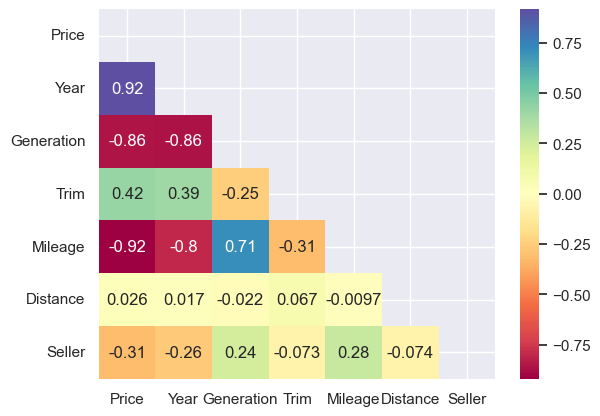

In [286]:
correlate(data, 'spearman')

,Price,Year,Mileage,Distance
Price,1.000000,0.329364,-0.759532,0.077803
Year,0.329364,1.000000,-0.228523,-0.087804
Mileage,-0.759532,-0.228523,1.000000,0.006719
Distance,0.077803,-0.087804,0.006719,1.000000


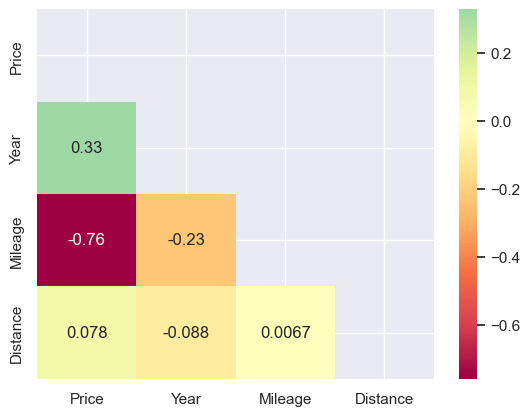

In [287]:
correlate(gen7_st3_private_data_dropped, 'pearson')

,Price,Year,Mileage,Distance
Price,1.000000,0.257316,-0.572295,0.079818
Year,0.257316,1.000000,-0.198621,-0.028742
Mileage,-0.572295,-0.198621,1.000000,-0.003792
Distance,0.079818,-0.028742,-0.003792,1.000000


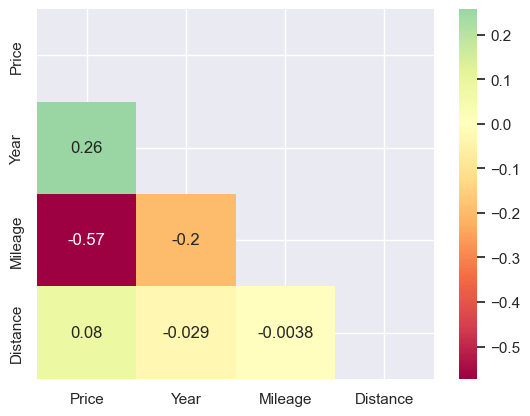

In [288]:
correlate(gen7_st3_private_data_dropped, 'kendall')

,Price,Year,Mileage,Distance
Price,1.000000,0.340626,-0.748207,0.104062
Year,0.340626,1.000000,-0.267087,-0.055943
Mileage,-0.748207,-0.267087,1.000000,-0.015629
Distance,0.104062,-0.055943,-0.015629,1.000000


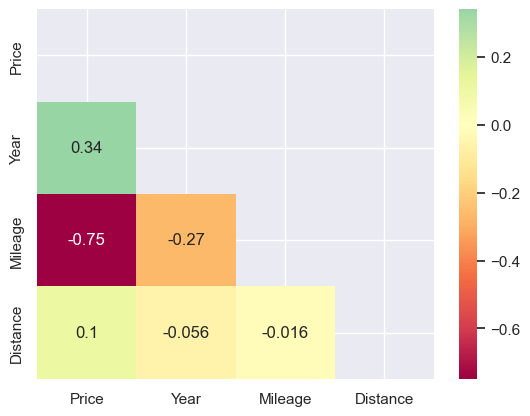

In [289]:
correlate(gen7_st3_private_data_dropped, 'spearman')

### Variance inflation factors

In [138]:
variables = data[['Year', 'Generation', 'Trim', 'Mileage', 'Distance', 'Seller']]
# variables = data[['Generation', 'Trim', 'Mileage', 'Distance', 'Seller']]
# variables = data[['Year', 'Trim', 'Mileage', 'Distance', 'Seller']]
# variables = gen7_data[['Year', 'Trim', 'Mileage', 'Distance', 'Seller']]
# variables = gen7_data[['Trim', 'Mileage', 'Distance', 'Seller']]
calculate_vif(variables)

,features,VIF
0,Year,12.885280
1,Generation,4.172482
2,Trim,2.592994
3,Mileage,8.118682
4,Distance,7.019852
5,Seller,1.389587


## Clustering

In [139]:
data_scaled = preprocessing.scale(data)

In [290]:
wcss =[]
for i in range(1,6):
    kmeans = KMeans(i)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,6),wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

c:\Users\jgibb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\jgibb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\jgibb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\jgibb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

Text(0, 0.5, 'WCSS')

c:\Users\jgibb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


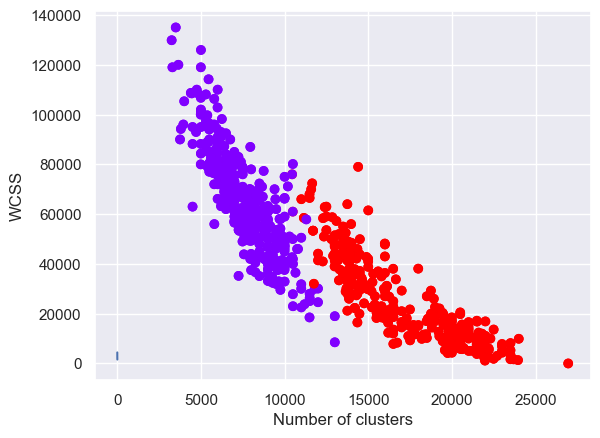

In [292]:
kmeans = KMeans(2)
clusters = kmeans.fit_predict(data_scaled)
plt.scatter(data['Price'], data['Mileage'], c=clusters, cmap='rainbow')
plt.show()

# Simple modelling for privately-sold generation 7 ST-3s

## Data

In [142]:
data_simple = gen7_st3_private_data_dropped.copy()
data_simple.describe()

,Price,Year,Mileage,Distance
count,52.000000,52.000000,52.000000,52.000000
mean,7782.692308,2015.500000,63853.884615,167.673077
std,1703.061851,1.128942,20482.956514,60.232791
min,4450.000000,2014.000000,18500.000000,7.000000
25%,6393.750000,2015.000000,50325.000000,132.000000
50%,7535.000000,2015.000000,67952.000000,174.000000
75%,9025.000000,2017.000000,78650.000000,200.000000
max,11490.000000,2017.000000,108518.000000,355.000000


In [143]:
X_simple = data_simple.copy()
X_simple = X_simple.drop(['Price'], axis=1)
y_simple = data_simple.copy()
y_simple = y_simple['Price']

In [144]:
scaler = StandardScaler()
X_simple_scaled = scaler.fit_transform(X_simple)

## VIF

In [145]:
def calculate_vif(variables):
    vif_data = pd.DataFrame()
    vif_data["features"] = variables.columns
    vif_data["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
    return vif_data

In [146]:
variables = data_simple[['Year', 'Mileage', 'Distance']]
calculate_vif(variables)

,features,VIF
0,Year,18.671949
1,Mileage,10.900671
2,Distance,8.899221


## OLS

In [147]:
def ols(dataset, xs, pred, title):
    print(title)
    print()
    y = dataset['Price']
    x1 = dataset[xs]
    x = sm.add_constant(x1)
    model_ols = sm.OLS(y,x).fit()
    p = sm.add_constant(pred, has_constant='add')
    predictions = model_ols.predict(p)
    print(f'Prediction: £{int(predictions[0])}')
    print()
    return model_ols.summary()

In [148]:
ols(data_simple, ['Year', 'Mileage', 'Distance'], mine_simple, 'OLS for gen7 ST-3 private data')
# ols(data_simple, ['Year', 'Mileage'], 'Gen7 ST-3 private data, no distance (insignificant)')

OLS for gen7 ST-3 private data

Prediction: £9262



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     25.24
Date:                Tue, 01 Oct 2024   Prob (F-statistic):           6.03e-10
Time:                        19:33:04   Log-Likelihood:                -435.55
No. Observations:                  52   AIC:                             879.1
Df Residuals:                      48   BIC:                             886.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.157e+05   2.82e+05     -1.828      0.074   -1.08e+06    5.14e+04
Year         261.4098    139.866      1.869      0.068     -19.811     542.630
Mileage       -0.0599      0.008     -7.802      0.000      -0.075      -0.044
Distance       2.7670      2.552      1.084      0.284      -2.365       7.899
==============================================================================
Omnibus:                       15.834   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.808
Skew:                           1.119   Prob(JB):                     5.00e-05
Kurtosis:                       5.033   Cond. No.                     1.25e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Linear regressions

In [240]:
# Unsplit

model_lr_simple_unsplit = LinearRegression()
model_lr_simple_unsplit.fit(X_simple, y_simple)

cv = 10

mae_lr_simple_cv_unsplit = cross_val_score(model_lr_simple_unsplit, X_simple, y_simple, cv=cv, scoring='neg_mean_absolute_error')
mse_lr_simple_cv_unsplit = cross_val_score(model_lr_simple_unsplit, X_simple, y_simple, cv=cv, scoring='neg_mean_squared_error')
r2_lr_simple_cv_unsplit = cross_val_score(model_lr_simple_unsplit, X_simple, y_simple, cv=cv, scoring='r2')

# Split

X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(X_simple, y_simple, test_size=0.08, random_state=42)

model_lr_simple_split = LinearRegression()
model_lr_simple_split.fit(X_train_simple, y_train_simple)

model_lr_simple_split_summary = pd.DataFrame(X_simple.columns.values, columns=['Features'])

p_lr_simple_split = model_lr_simple_split.predict(X_test_simple).astype(int)

mae_lr_simple_split = mean_absolute_error(y_test_simple, p_lr_simple_split)
mse_lr_simple_split = mean_squared_error(y_test_simple, p_lr_simple_split)

mae_lr_simple_cv_split = cross_val_score(model_lr_simple_split, X_train_simple, y_train_simple, cv=cv, scoring='neg_mean_absolute_error')
mse_lr_simple_cv_split = cross_val_score(model_lr_simple_split, X_train_simple, y_train_simple, cv=cv, scoring='neg_mean_squared_error')
r2_lr_simple_cv_split = cross_val_score(model_lr_simple_split, X_train_simple, y_train_simple, cv=cv, scoring='r2')

# Results

results_lr_simple = {
    'Metric': ['MAE', 'MSE', 'CV MAE', 'CV MSE', 'CV R²', 'Prediction'],
    'Unsplit': [
        '',
        '',
        f"{int(mae_lr_simple_cv_unsplit.mean())}",
        f"{int(mse_lr_simple_cv_unsplit.mean())}",
        f"{r2_lr_simple_cv_unsplit.mean():.3f}",
        f"£{int(model_lr_simple_unsplit.predict(mine_simple)[0])}"
    ],
    'Split': [
        f"{int(mae_lr_simple_split)}",
        f"{int(mse_lr_simple_split)}",
        f"{int(mae_lr_simple_cv_split.mean())}",
        f"{int(mse_lr_simple_cv_split.mean())}",
        f"{r2_lr_simple_cv_split.mean():.3f}",
        f"£{int(model_lr_simple_split.predict(mine_simple)[0])}"
    ]
}
results_lr_simple_df = pd.DataFrame(results_lr_simple)

model_lr_simple_summary = pd.DataFrame(X_simple.columns.values, columns=['Features'])
model_lr_simple_summary['Weights (unsplit)'] = model_lr_simple_unsplit.coef_
model_lr_simple_summary['Weights (split)'] = model_lr_simple_split.coef_

# Can only show one prettily

display(results_lr_simple_df)
print()
display(model_lr_simple_summary)

,Metric,Unsplit,Split
0,MAE,,1192
1,MSE,,2507562
2,CV MAE,-871,-867
3,CV MSE,-1312737,-1251803
4,CV R²,0.277,-0.062
5,Prediction,£9262,£9213


,Features,Weights (unsplit),Weights (split)
0,Year,261.409791,238.836566
1,Mileage,-0.059914,-0.062248
2,Distance,2.766963,2.707237


## Lasso, Ridge, Elastic Net

In [239]:
lasso_model = Lasso()
ridge_model = Ridge()
en_model = ElasticNet()

cv = 10

la_scores = cross_val_score(lasso_model, X_simple_scaled, y_simple, cv=cv, scoring='neg_mean_absolute_error')
print(f'Lasso CV MAE:\t\t{-int(la_scores.mean())}')
r_scores = cross_val_score(ridge_model, X_simple_scaled, y_simple, cv=cv, scoring='neg_mean_absolute_error')
print(f'Ridge CV MAE:\t\t{-int(r_scores.mean())}')
en_scores = cross_val_score(en_model, X_simple_scaled, y_simple, cv=cv, scoring='neg_mean_absolute_error')
print(f'Elastic Net CV MAE:\t{-int(en_scores.mean())}')

alpha_values = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000]

param_grid = {'alpha': alpha_values}
grid_search_lasso = GridSearchCV(lasso_model, param_grid, cv=cv, scoring='neg_mean_absolute_error')
grid_search_lasso.fit(X_simple_scaled, y_simple)
test_score_lasso = grid_search_lasso.best_estimator_.score(X_simple_scaled, y_simple)

param_grid = {'alpha': alpha_values}
grid_search_ridge = GridSearchCV(ridge_model, param_grid, cv=cv, scoring='neg_mean_absolute_error')
grid_search_ridge.fit(X_simple_scaled, y_simple)
test_score_ridge = grid_search_ridge.best_estimator_.score(X_simple_scaled, y_simple)

l1_ratios = np.linspace(0, 1, 11)
param_grid_en = {'alpha': alpha_values, 'l1_ratio': l1_ratios}
grid_search_en = GridSearchCV(en_model, param_grid_en, cv=cv, scoring='neg_mean_absolute_error')
grid_search_en.fit(X_simple_scaled, y_simple)
test_score_en = grid_search_en.best_estimator_.score(X_simple_scaled, y_simple)
print()
print(f"Elastic Net best l1 ratio value: {grid_search_en.best_params_['l1_ratio']}")

results_lre_simple = {
    'Metric': ['Alpha', 'CV MAE', 'CV R²'],
    'Lasso': [
        f"{grid_search_lasso.best_params_['alpha']}",
        f"{-int(grid_search_lasso.best_score_)}",
        f"{test_score_lasso:.3f}"
    ],
    'Ridge': [
        f"{grid_search_ridge.best_params_['alpha']}",
        f"{-int(grid_search_ridge.best_score_)}",
        f"{test_score_ridge:.3f}"
    ],
    'Elastic Net': [
        f"{grid_search_en.best_params_['alpha']}",
        f"{-int(grid_search_en.best_score_)}",
        f"{test_score_en:.3f}"
    ]
}
results_lre_simple_df = pd.DataFrame(results_lre_simple)
display(results_lre_simple_df)


Lasso CV MAE:		871
Ridge CV MAE:		874
Elastic Net CV MAE:	959

Elastic Net best l1 ratio value: 1.0


,Metric,Lasso,Ridge,Elastic Net
0,Alpha,1e-10,1e-10,1e-10
1,CV MAE,871,871,871
2,CV R²,0.612,0.612,0.612


In [249]:
grid_search_lasso.best_estimator_.fit(X_train_simple, y_train_simple)
print(f'Prediction: £{int(grid_search_lasso.best_estimator_.predict(mine_simple)[0])}')

Prediction: £9213


## Leave-one-out cross validation (LOOCV)

In [152]:
loo = LeaveOneOut()
model_loo = LinearRegression()

predictions_loo = []
actual_prices = []

for train_index, test_index in loo.split(X_simple):
    X_train, X_test = X_simple.iloc[train_index], X_simple.iloc[test_index]
    y_train, y_test = y_simple.iloc[train_index], y_simple.iloc[test_index]
    model_loo.fit(X_train, y_train)
    y_pred = model_loo.predict(X_test)
    predictions_loo.append(y_pred[0])
    actual_prices.append(y_test.values[0])

mae_loo = mean_absolute_error(actual_prices, predictions_loo)
mse_loo = mean_squared_error(actual_prices, predictions_loo)
print(f'Mean Absolute Error: {int(mae_loo)}')
print(f'Mean Squared Error: {int(mse_loo)}')
print()

model_loo.fit(X_simple, y_simple)
print(f'Prediction: £{int(model_loo.predict(mine_simple)[0])}')

Mean Absolute Error: 897
Mean Squared Error: 1338939

Prediction: £9262


# More complex modelling for the entire dataset

In [153]:
ols(data, ['Year','Generation','Trim','Mileage','Distance','Seller'], mine_all, 'All data, all columns')
# ols(data, mine_all,['Generation','Trim','Mileage','Distance','Seller'], 'All data, no year (high correlation)')
# ols(data, mine_all,['Generation','Trim','Mileage','Seller'], 'All data, no year (high correlation), no distance (insignificant)')

All data, all columns

Prediction: £10980



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     2178.
Date:                Tue, 01 Oct 2024   Prob (F-statistic):               0.00
Time:                        19:33:15   Log-Likelihood:                -5368.3
No. Observations:                 634   AIC:                         1.075e+04
Df Residuals:                     627   BIC:                         1.078e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.505e+06   7.43e+04    -20.269      0.000   -1.65e+06   -1.36e+06
Year         753.8299     36.742     20.517      0.000     681.678     825.982
Generation -2174.8284    184.875    -11.764      0.000   -2537.878   -1811.779
Trim         947.6657    102.849      9.214      0.000     745.695    1149.636
Mileage       -0.0717      0.003    -25.943      0.000      -0.077      -0.066
Distance       0.5979      0.642      0.931      0.352      -0.663       1.859
Seller      -535.0937    116.945     -4.576      0.000    -764.744    -305.443
==============================================================================
Omnibus:                       66.765   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              252.696
Skew:                           0.415   Prob(JB):                     1.34e-55
Kurtosis:                       5.979   Cond. No.                     8.86e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.86e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [154]:
X = data.drop(['Price'], axis=1).copy()
y = data['Price'].copy()

In [155]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'XGBoost Regressor': XGBRegressor(random_state=42)
}

In [157]:
preds = []

for name, model in models.items():
    model.fit(X,y)
    pred = model.predict(mine_all).astype(int)[0]
    preds.append(pred)
    print(f'{name.ljust(30)}£{pred}')

print('-'*36)
print(f'MEAN{"":<26}£{int(np.mean(preds))}')

model_lr_summary = pd.DataFrame(X.columns.values, columns=['Features'])
model_lr_summary['Weights'] = models['Linear Regression'].coef_
model_lr_summary


Linear Regression             £10980
Ridge Regression              £11000
Lasso Regression              £10988
Decision Tree Regressor       £9750
Random Forest Regressor       £10047
Gradient Boosting Regressor   £9719
XGBoost Regressor             £10287
------------------------------------
MEAN                          £10395


,Features,Weights
0,Year,753.829947
1,Generation,-2174.828447
2,Trim,947.665727
3,Mileage,-0.071659
4,Distance,0.597924
5,Seller,-535.093658


## Split

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [159]:
results_split = pd.DataFrame()

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = int(mean_absolute_error(y_test, y_pred))
    mse = int(mean_squared_error(y_test, y_pred))
    r2 = round(r2_score(y_test, y_pred),3)
    pred = f'£{int(model.predict(mine_all)[0])}'
    results_split = pd.concat([results_split, pd.DataFrame({'Model': [name], 'MAE': [mae], 'MSE': [mse], 'R²': [r2], 'Prediction': [pred]})], ignore_index=True)

results_split

,Model,MAE,MSE,R²,Prediction
0,Linear Regression,922,1472099,0.953,£11015
1,Ridge Regression,920,1468807,0.953,£11038
2,Lasso Regression,921,1471149,0.953,£11023
3,Decision Tree Regressor,877,1310080,0.958,£9500
4,Random Forest Regressor,733,920661,0.971,£10135
5,Gradient Boosting Regressor,685,845839,0.973,£9857
6,XGBoost Regressor,742,923026,0.970,£9917


## Cross validation

In [190]:
n_iter = 100
cv = 10

In [191]:
results_cv = pd.DataFrame()

for name, model in models.items():
    maes = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
    maes_mean = -int(maes.mean())
    maes_std = int(maes.std())
    mses = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    mses_mean = -int(mses.mean())
    mses_std = int(mses.std())
    r2s = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
    r2s_mean = round(r2s.mean(),3)
    r2s_std = round(r2s.std(),3)
    pred = f'£{int(model.predict(mine_all)[0])}'
    results_cv = pd.concat([results_cv, pd.DataFrame({'CV\'d Model': [name], 'MAE': [maes_mean], 'MAE STD': [maes_std], 'MSE': [mses_mean], 'MSE STD': [mses_std], 'R²': [r2s_mean], 'R² STD': [r2s_std], 'Prediction': [pred]})], ignore_index=True)

results_cv

,CV'd Model,MAE,MAE STD,MSE,MSE STD,R²,R² STD,Prediction
0,Linear Regression,876,105,1339522,395831,0.951,0.013,£11015
1,Ridge Regression,876,105,1340025,401464,0.951,0.013,£11038
2,Lasso Regression,876,105,1339694,397537,0.951,0.013,£11023
3,Decision Tree Regressor,939,110,1906197,1227880,0.930,0.046,£9500
4,Random Forest Regressor,718,85,992339,339443,0.964,0.012,£10135
5,Gradient Boosting Regressor,660,95,826175,314020,0.970,0.009,£9857
6,XGBoost Regressor,726,107,1128356,617047,0.959,0.022,£9917


## RandomizedSearchCV

### XGBoost

In [293]:
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
}
total_combinations = reduce(mul, [len(v) for v in param_grid_xgb.values()])
print(f'Total parameter combinations: {total_combinations:,}')

model_xgb = XGBRegressor(random_state=42)
rs_xgb = RandomizedSearchCV(model_xgb, param_distributions=param_grid_xgb, n_iter=n_iter, cv=cv, random_state=42, scoring ='neg_mean_absolute_error')
rs_xgb.fit(X_train,y_train)

print(f'Best MAE: {int(-rs_xgb.best_score_)}')
print(f'Params: {rs_xgb.best_params_}')
model_xgb_rscv_best = XGBRegressor(random_state=42, **rs_xgb.best_params_)
print(f'R²: {round(cross_val_score(model_xgb_rscv_best, X_train, y_train, cv=cv, scoring='r2').mean(),3)}')
model_xgb_rscv_best.fit(X_train, y_train)
print(f'Prediction: £{int(model_xgb_rscv_best.predict(mine_all)[0])}')

Total parameter combinations: 77,760
Best MAE: 626
Params: {'subsample': 0.7, 'reg_lambda': 0, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
R²: 0.973
Prediction: £9857


### Gradient boosting

In [295]:
learning_rate_range = np.arange(0.1, 1.1, 0.1)
learning_rate_range = np.round(learning_rate_range, decimals=1)
learning_rate_range = learning_rate_range.tolist()
n_estimators_range = list(range(100,1001,50))
max_depth_range = list(range(1,11))
param_grid_gb = {
    'learning_rate': learning_rate_range,
    'n_estimators': n_estimators_range,
    'max_depth': max_depth_range,
    'criterion': ['squared_error', 'friedman_mse']
}
total_combinations = reduce(mul, [len(v) for v in param_grid_gb.values()])
print(f'Total parameter combinations: {total_combinations}')

model_gb = GradientBoostingRegressor(random_state=42)
rs_gb = RandomizedSearchCV(model_gb, param_distributions=param_grid_gb, n_iter=n_iter, cv=cv, random_state=42, scoring ='neg_mean_absolute_error')
rs_gb.fit(X_train,y_train)

print(f'Best MAE: {int(-rs_gb.best_score_)}')
print(f'Params: {rs_gb.best_params_}')
model_gb_rscv_best = GradientBoostingRegressor(random_state=42, **rs_gb.best_params_)
print(f'R²: {round(cross_val_score(model_gb_rscv_best, X_train, y_train, cv=cv, scoring='r2').mean(),3)}')
model_gb_rscv_best.fit(X_train, y_train)
print(f'Prediction: £{int(model_gb_rscv_best.predict(mine_all)[0])}')

Total parameter combinations: 3800
Best MAE: 672
Params: {'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.2, 'criterion': 'friedman_mse'}
R²: 0.969
Prediction: £10027


### Random forest

In [297]:
n_estimators_range = list(range(50,201,50))
max_depth_range = list(range(1,21))
min_samples_split_range = list(range(2,22))
param_grid_rf = {
    'n_estimators': n_estimators_range,
    'max_depth': max_depth_range,
    'min_samples_split': min_samples_split_range,
    'criterion': ['squared_error', 'friedman_mse']
}
total_combinations = reduce(mul, [len(v) for v in param_grid_rf.values()])
print(f'Total parameter combinations: {total_combinations}')

model_rf = RandomForestRegressor(random_state=42)
rs_rf = RandomizedSearchCV(model_rf, param_distributions=param_grid_rf, n_iter=n_iter, cv=cv, random_state=42, scoring ='neg_mean_absolute_error')
rs_rf.fit(X_train,y_train)

print(f'Best MAE: {int(-rs_rf.best_score_)}')
print(f'Params: {rs_rf.best_params_}')
model_rf_rscv_best = RandomForestRegressor(random_state=42, **rs_rf.best_params_)
print(f'R²: {round(cross_val_score(model_rf_rscv_best, X_train, y_train, cv=cv, scoring='r2').mean(),3)}')
model_rf_rscv_best.fit(X_train, y_train)
print(f'Prediction: £{int(model_rf_rscv_best.predict(mine_all)[0])}')

Total parameter combinations: 3200
Best MAE: 705
Params: {'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 17, 'criterion': 'friedman_mse'}
R²: 0.965
Prediction: £10021


## BayesSearchCV

### XGBoost

In [300]:
param_grid_xgb = {
    'n_estimators': (100, 2000),
    'learning_rate': (0.001, 0.1),
    'max_depth': (1, 10),
    'min_child_weight': (1, 10),
    'subsample': (0, 1.0),
    'colsample_bytree': (0, 1.0),
    'gamma': (0, 0.5),
    'reg_alpha': (0, 1.0),
    'reg_lambda': (0, 1.0),
}
scoring=make_scorer(lambda y_true, y_pred: -mean_absolute_error(y_true, y_pred))

model_xgb = XGBRegressor(random_state=42)
opt_xgb = BayesSearchCV(model_xgb, param_grid_xgb, n_iter=n_iter, cv=cv, random_state=42, scoring=scoring)
opt_xgb.fit(X_train, y_train)
model_xgb_bscv_best = opt_xgb.best_estimator_
print(f'Best MAE: {int(-opt_xgb.best_score_)}')
# print(f'Best R²: {round(-opt_xgb.best_score_,3)}') # for r2 (default)s scoring
print(f'Params: {dict(opt_xgb.best_params_)}')
model_xgb_bscv_best_r2 = round(cross_val_score(model_xgb_bscv_best, X_train, y_train, cv=cv, scoring='r2').mean(),5)
print(f'R²: {model_xgb_bscv_best_r2}')
model_xgb_bscv_best.fit(X_train, y_train)
print(f'Prediction: £{int(model_xgb_bscv_best.predict(mine_all)[0])}')

Best MAE: 624
Params: {'colsample_bytree': 0.7270539248144664, 'gamma': 0.5, 'learning_rate': 0.014211596095931155, 'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 569, 'reg_alpha': 0.4656981380370553, 'reg_lambda': 0.7971355695281127, 'subsample': 0.7864790128496011}
R²: 0.97228
Prediction: £10170


### Gradient boosting

In [301]:
param_grid_gb = {
    'n_estimators': (100, 2000),
    'learning_rate': (0.001, 0.1),
    'max_depth': (1, 10),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10), 
    'max_features': Categorical([1, 2, 'sqrt', 'log2']),
    'subsample': (0.01, 1.0),
    'alpha': (0.01, 0.99),
}
scoring=make_scorer(lambda y_true, y_pred: -mean_absolute_error(y_true, y_pred))

model_gb = GradientBoostingRegressor(random_state=42)
opt_gb = BayesSearchCV(model_gb, param_grid_gb, n_iter=n_iter, cv=cv, random_state=42, scoring=scoring)
opt_gb.fit(X_train, y_train)
model_gb_bscv_best = opt_gb.best_estimator_
print(f'Best MAE: {int(-opt_gb.best_score_)}')
print(f'Params: {dict(opt_gb.best_params_)}')
model_gb_bscv_best_r2 = round(cross_val_score(model_gb_bscv_best, X_train, y_train, cv=cv, scoring='r2').mean(),5)
print(f'R²: {model_gb_bscv_best_r2}')
model_gb_bscv_best.fit(X_train, y_train)
print(f'Prediction: £{int(model_gb_bscv_best.predict(mine_all)[0])}')

Best MAE: 612
Params: {'alpha': 0.5664550052432248, 'learning_rate': 0.031326678032625066, 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 6, 'min_samples_split': 7, 'n_estimators': 474, 'subsample': 0.5875524003502206}
R²: 0.97545
Prediction: £9921


### Random forest

In [302]:
param_grid_rf = {
    'n_estimators': (50, 300),
    'max_depth': (1, 20),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10),
    'max_features': (None, 'sqrt', 'log2'),
    'criterion': ['squared_error', 'friedman_mse'],
}
scoring=make_scorer(lambda y_true, y_pred: -mean_absolute_error(y_true, y_pred))

model_rf = RandomForestRegressor(random_state=42)
opt_rf = BayesSearchCV(model_rf, param_grid_rf, n_iter=n_iter, cv=cv, random_state=42, scoring=scoring) # n_jobs=1
opt_rf.fit(X_train, y_train)
model_rf_bscv_best = opt_rf.best_estimator_
print(f'Best MAE: {int(-opt_rf.best_score_)}')
print(f'Parameters: {dict(opt_rf.best_params_)}')
model_rf_bscv_best_r2 = round(cross_val_score(model_rf_bscv_best, X_train, y_train, cv=cv, scoring='r2').mean(),5)
print(f'R²: {model_rf_bscv_best_r2}')
model_rf_bscv_best.fit(X_train, y_train)
print(f'Prediction: £{int(model_rf_bscv_best.predict(mine_all)[0])}')

c:\Users\jgibb\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['friedman_mse', 17, 'sqrt', 1, 2, 300] before, using random point ['squared_error', 17, 'sqrt', 8, 4, 295]
  warnings.warn(
c:\Users\jgibb\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['friedman_mse', 17, 'sqrt', 1, 2, 300] before, using random point ['squared_error', 17, 'log2', 7, 3, 178]
  warnings.warn(
c:\Users\jgibb\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['friedman_mse', 17, 'log2', 2, 2, 300] before, using random point ['friedman_mse', 3, 'sqrt', 5, 3, 217]
  warnings.warn(
c:\Users\jgibb\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['friedman_mse', 20, 'sqrt', 1, 2, 300] before, using random point ['friedman_mse', 12, None, 9, 6,

Best MAE: 662
Parameters: {'criterion': 'friedman_mse', 'max_depth': 17, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
R²: 0.97148
Prediction: £9510


## GridSearchCVs

### XGBoost

In [303]:
param_grid_xgb_gs = {
    'n_estimators': [500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [5, 6],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0],
    'reg_lambda': [0.4, 0.5, 0.6],
}

params = { 'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'criterion': 'friedman_mse' }
model_xgb_timer = GradientBoostingRegressor(random_state=42, **params)
start_time = time.time()
for i in range(10):
    model_xgb_timer.fit(X_train, y_train)
end_time = time.time()
sample_fit_time = end_time - start_time
print(f"Time taken for 10 fits: {sample_fit_time:.4f} seconds")

cv = 5
# fits = reduce(mul, [len(v) for v in param_grid_xgb.values()])
fits = math.prod(len(i) for i in param_grid_xgb_gs.values())
cvsandstats = cv * 3
print(f"Total number of fits: {fits} x {cvsandstats} = {fits*cvsandstats:,}")
print(f"Approximate time for all fits: {sample_fit_time/10*(fits*cvsandstats)/60:.2f} minutes")

Time taken for 10 fits: 0.8207 seconds
Total number of fits: 9000 x 15 = 135,000
Approximate time for all fits: 184.65 minutes


In [304]:
# model_xgb = XGBRegressor(random_state=42)

# grid_search_xgb_mae = GridSearchCV(estimator=model_xgb, param_grid=param_grid_xgb_gs, cv=cv, scoring='neg_mean_absolute_error', error_score='raise')
# grid_search_xgb_mae.fit(X_train, y_train)
# print(f'grid_search_xgb_mae complete')
# print(f"Best Parameters (MAE): {grid_search_xgb_mae.best_params_}")
# print(f"Best Score (MAE): {-grid_search_xgb_mae.best_score_:.2f}")

# grid_search_xgb_mse = GridSearchCV(estimator=model_xgb, param_grid=param_grid_xgb_gs, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
# grid_search_xgb_mse.fit(X_train, y_train)
# print(f'grid_search_xgb_mse complete')
# print(f"Best Parameters (MSE): {grid_search_xgb_mse.best_params_}")
# print(f"Best Score (MSE): {-grid_search_xgb_mse.best_score_:.2f}")

# grid_search_xgb_r2 = GridSearchCV(estimator=model_xgb, param_grid=param_grid_xgb_gs, cv=cv, scoring='r2', error_score='raise')
# grid_search_xgb_r2.fit(X_train, y_train)
# print(f'grid_search_gb_r2 complete')
# print(f"Best Parameters (R²): {grid_search_xgb_r2.best_params_}")
# print(f"Best Score (R²): {grid_search_xgb_r2.best_score_:.2f}")

### Gradient boosting

In [305]:
learning_rate_range = np.arange(0.1, 1.1, 0.1)
learning_rate_range = np.round(learning_rate_range, decimals=1)
learning_rate_range = learning_rate_range.tolist()
n_estimators_range = list(range(100,1001,50))
max_depth_range = list(range(1,11))
param_grid_gb_gs = {
    'learning_rate': learning_rate_range,
    'n_estimators': n_estimators_range,
    'max_depth': max_depth_range,
    'criterion': ['squared_error', 'friedman_mse']
}

params = { 'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'criterion': 'friedman_mse' }
model_gb = GradientBoostingRegressor(random_state=42, **params)
start_time = time.time()
for i in range(10):
    model_gb.fit(X_train, y_train)
end_time = time.time()
sample_fit_time = end_time - start_time
print(f"Time taken for 10 fits: {sample_fit_time:.4f} seconds")

cv = 5
fits = reduce(mul, [len(v) for v in param_grid_gb_gs.values()])
cvsandstats = cv * 3
print(f"Total number of fits: {fits} x {cvsandstats} = {fits*cvsandstats:,}")
print(f"Approximate time for all fits: {sample_fit_time/10*(fits*cvsandstats)/60:.2f} minutes")

Time taken for 10 fits: 0.7875 seconds
Total number of fits: 3800 x 15 = 57,000
Approximate time for all fits: 74.81 minutes


In [306]:
# model_gb = GradientBoostingRegressor(random_state=42)

# grid_search_gb_mae = GridSearchCV(estimator=model_gb, param_grid=param_grid_gb_gs, cv=cv, scoring='neg_mean_absolute_error', error_score='raise')
# grid_search_gb_mae.fit(X_train, y_train)
# print(f'grid_search_gb_mae complete')
# print(f"Best Parameters (MAE): {grid_search_gb_mae.best_params_}")
# print(f"Best Score (MAE): {-grid_search_gb_mae.best_score_:.2f}")

# grid_search_gb_mse = GridSearchCV(estimator=model_gb, param_grid=param_grid_gb_gs, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
# grid_search_gb_mse.fit(X_train, y_train)
# print(f'grid_search_gb_mse complete')
# print(f"Best Parameters (MSE): {grid_search_gb_mse.best_params_}")
# print(f"Best Score (MSE): {-grid_search_gb_mse.best_score_:.2f}")

# grid_search_gb_r2 = GridSearchCV(estimator=model_gb, param_grid=param_grid_gb_gs, cv=cv, scoring='r2', error_score='raise')
# grid_search_gb_r2.fit(X_train, y_train)
# print(f'grid_search_gb_r2 complete')
# print(f"Best Parameters (R²): {grid_search_gb_r2.best_params_}")
# print(f"Best Score (R²): {grid_search_gb_r2.best_score_:.2f}")

### Random forest

In [307]:
n_estimators_range = list(range(50,201,50))
max_depth_range = list(range(1,21))
min_samples_split_range = list(range(2,22))
param_grid_rf_gs = {
    'n_estimators': n_estimators_range,
    'max_depth': max_depth_range,
    'min_samples_split': min_samples_split_range,
    'criterion': ['squared_error', 'absolute_error']
}

params = { 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 10, 'criterion': 'squared_error' }
model_rf = RandomForestRegressor(random_state=42, **params)
start_time = time.time()
for i in range(10):
    model_rf.fit(X_train, y_train)
end_time = time.time()
sample_fit_time = end_time - start_time
print(f"Time taken for 10 fits: {sample_fit_time:.4f} seconds")

cv = 5
fits = reduce(mul, [len(v) for v in param_grid_rf_gs.values()])
cvsandstats = cv * 3
print(f"Total number of fits: {fits} x {cvsandstats} = {fits*cvsandstats:,}")
print(f"Approximate time for all fits: {sample_fit_time/10*(fits*cvsandstats)/60:.2f} minutes")

Time taken for 10 fits: 0.8712 seconds
Total number of fits: 3200 x 15 = 48,000
Approximate time for all fits: 69.70 minutes


In [308]:
# model_rf = RandomForestRegressor(random_state=42)

# grid_search_rf_mae = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf_gs, cv=cv, scoring='neg_mean_absolute_error', error_score='raise')
# grid_search_rf_mae.fit(X_train, y_train)
# print(f'grid_search_rf_mae complete')

# grid_search_rf_mse = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf_gs, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
# grid_search_rf_mse.fit(X_train, y_train)
# print(f'grid_search_rf_mse complete')

# grid_search_rf_r2 = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf_gs, cv=cv, scoring='r2', error_score='raise')
# grid_search_rf_r2.fit(X_train, y_train)
# print(f'grid_search_rf_r2 complete')
# print()

# print(f"Best Parameters (MAE): {grid_search_rf_mae.best_params_}")
# print(f"Best Parameters (MSE): {grid_search_rf_mse.best_params_}")
# print(f"Best Parameters (R²): {grid_search_rf_r2.best_params_}")
# print()
# print(f"Best Score (MAE): {-grid_search_rf_mae.best_score_:.2f}")
# print(f"Best Score (MSE): {-grid_search_rf_mse.best_score_:.2f}")
# print(f"Best Score (R²): {grid_search_rf_r2.best_score_:.2f}")

## pymc

In [309]:
import pymc as pm
with pm.Model() as model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_year = pm.Normal('beta_year', mu=0, sigma=10)
    beta_mileage = pm.Normal('beta_mileage', mu=0, sigma=10)

    # Expected value of outcome
    mu = alpha + beta_year * data['Year'] + beta_mileage * data['Mileage']

    # Likelihood (sampling distribution) of observations
    sigma = pm.HalfNormal('sigma', sigma=1)
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=data['Price'])

    # Inference
    trace = pm.sample(2000, return_inferencedata=False)
pm.plot_trace(trace)
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_year, beta_mileage, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4189 seconds.


ValueError: Can only convert xarray dataarray, xarray dataset, dict, netcdf filename, numpy array, pystan fit, emcee fit, pyro mcmc fit, numpyro mcmc fit, cmdstan fit csv filename, cmdstanpy fit to InferenceData, not MultiTrace

## Paired t-tests

In [ ]:
# t_stat, p_value = ttest_rel(cv_scores_lr, cv_scores_gb)

# print(f"Paired t-test (lr, gb) - t-statistic:\t{t_stat:.2f}")
# print(f"Paired t-test (lr, gb) - p-value:\t{p_value:.2f}")

# Conclusion

In [316]:
best1 = int(grid_search_lasso.best_estimator_.predict(mine_simple)[0])
print(f'Linear (lasso) regression for gen7 privately-sold ST3s\t(MAE {int(-grid_search_lasso.best_score_)}, R² {test_score_lasso:.3f})\t£{best1}')
print()
best2 = int(model_gb_bscv_best.predict(mine_all)[0])
print(f'Optimised gradient boosting regression for all STs\t(MAE {int(-opt_gb.best_score_)}, R² {model_gb_bscv_best_r2:.3f})\t£{best2}')

Linear (lasso) regression for gen7 privately-sold ST3s	(MAE 871, R² 0.612)	£9213

Optimised gradient boosting regression for all STs	(MAE 612, R² 0.975)	£9921


In [ ]:
best = best1

st3_data_sorted = st3_data_dropped.sort_values(by='Price').reset_index()
d = 0.02
st3_data_sorted[(st3_data_sorted['Price'] > best*(1-d)) & (st3_data_sorted['Price'] < best*(1+d))]

,index,Price,Year,Generation,Mileage,Distance,Seller
106,81,9100,2017,1,33000,134,1
107,129,9150,2017,1,62000,159,0
108,210,9300,2015,1,32379,185,0
